### Test EEG data

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

from lib.bandits import LinUCB, ThresholdBandit, GreedyBandit, ThresholdConsBandit
from lib.generator import DataGenerator, DataGeneratorParams
import numpy as np 
import pandas
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
sns.set_style('ticks')

def first_nonzero(arr, axis, invalid_val=-1):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def smooth(y, box_pts=100):
    box = np.ones(box_pts)/box_pts
    if len(y.shape) == 2:
        y_smooth = y.copy()
        for i in range(y.shape[0]):
            y_smooth[i,:] = np.convolve(y[i,:], box, mode='same')
    else:
        y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def load_data(fn_in):
    df = pandas.read_csv(fn_in)
    #df = shuffle(df)
    df = df.sample(frac=1).reset_index(drop=True)
    #Center and scale the data....
    d = df.shape[1]-1
    for i in range(d):
        idx = 'V%d'%(i+1)
        df[idx] = (df[idx] - df[idx].mean())/df[idx].std()
    dparams = DataGeneratorParams(df, df.shape[1]-1, intercept = intercept)
    dgenerator = DataGenerator(dparams)
    return dparams, dgenerator

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/home/lansdell/.local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
intercept = True #constant term in linear model
M = 10            #number of runs
lambd = 1e-4
fn_in = 'EEG.csv'
save = True

In [3]:
dparams, dgenerator = load_data(fn_in)
N = dparams.df.shape[0]-1       #number of timesteps
k = dparams.k           #number of arms
d = dparams.d           #dimension of context (includes one dim for intercept term if present)
delta = 1./N          #confidence level, adjusted for horizon

## Look at the dataset

In [4]:
dparams, dgenerator = load_data(fn_in)
dparams.df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class,ones
0,-0.020938,-0.324274,-0.321473,-0.014318,0.023574,-0.010843,-0.013517,-0.635550,-0.019133,-0.688189,-0.431560,-0.339463,-0.004945,-0.014455,2,1.0
1,-0.015380,-0.491660,0.059592,-0.010779,-0.138781,-0.011369,-0.011845,-0.233059,-0.011691,0.363035,-0.146533,-0.438153,-0.013005,-0.010973,1,1.0
2,-0.011471,0.066439,-0.032917,-0.010091,0.008893,-0.004883,-0.010509,0.169773,-0.006893,-0.122105,-0.282298,-0.240774,-0.018525,-0.012190,1,1.0
3,-0.011263,-0.491660,-0.055875,-0.010681,-0.005788,-0.011195,-0.010730,-0.233059,-0.007132,-0.162577,0.328511,-0.018601,-0.002826,-0.008536,1,1.0
4,0.013636,-0.257233,0.278823,-0.005273,-0.507820,-0.014351,-0.007053,-0.495583,-0.015534,-0.135771,-0.648571,0.277709,0.027735,0.001737,2,1.0


In [5]:
ctx = dgenerator.context()
linucb = LinUCB(dgenerator, delta, n_pulls=N, lambd = lambd)
linucb.arms(ctx,0)
self = linucb
arm_idx = self._choose_arm(ctx)
theta = np.dot(np.linalg.inv(self.V), self.U)
ucbs = []
arms = [self.arms(ctx, i) for i in range(self.k)]
arm = np.atleast_2d(arms[0]).T
ucb = np.dot(theta.T, arm)+self.beta(self.V)*np.sqrt(np.dot(arm.T, np.dot(np.linalg.inv(self.V), arm)))
v = self.V
L = 1
np.sqrt(self.lamd)*L + np.sqrt(np.log(np.linalg.det(v))-self.d*np.log(self.lamd)-2*np.log(delta))
delta

6.676013084985647e-05

## Run online learning algs

In [6]:
regret_ucb = np.zeros((M,N))
for j in range(M):
    print("Run %d/%d"%(j+1,M))
    dparams, dgenerator = load_data(fn_in)
    linucb = LinUCB(dgenerator, delta, n_pulls=N, lambd = lambd)
    for i in range(N):
        (ctx, arm_idx, obs, reg) = linucb.step()
        regret_ucb[j,i] = reg

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


In [7]:
regret_thr = np.zeros((M,N))
for j in range(M):
    print("Run %d/%d"%(j+1,M))
    dparams, dgenerator = load_data(fn_in)
    thresholdbandit = ThresholdBandit(dgenerator, delta, n_pulls = N, lambd = lambd)
    for i in range(N):
        (ctx, arm_idx, obs, reg) = thresholdbandit.step()
        regret_thr[j,i] = reg

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


In [8]:
regret_conthr = np.zeros((M,N))
for j in range(M):
    print("Run %d/%d"%(j+1,M))
    dparams, dgenerator = load_data(fn_in)
    thresholdbandit = ThresholdConsBandit(dgenerator, delta, n_pulls = N, lambd = lambd)
    for i in range(N):
        (ctx, arm_idx, obs, reg) = thresholdbandit.step()
        regret_conthr[j,i] = reg

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


In [9]:
regret_gre = np.zeros((M,N))
for j in range(M):
    print("Run %d/%d"%(j+1,M))
    dparams, dgenerator = load_data(fn_in)
    thresholdbandit = GreedyBandit(dgenerator, delta, n_pulls = N, lambd = lambd)
    for i in range(N):
        (ctx, arm_idx, obs, reg) = thresholdbandit.step()
        regret_gre[j,i] = reg

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


## The oracle

In [ ]:
#Fit least squares with all the data


#Predict 

## The regret

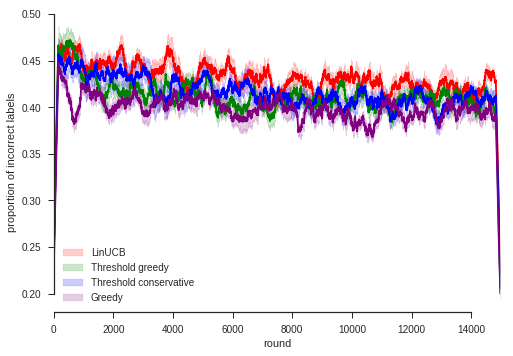

In [11]:
#plt.plot(smooth(np.mean(regret_ucb, axis = 0), box_pts = 500))
#plt.plot(smooth(np.mean(regret_thr, axis = 0), box_pts = 500))
#plt.plot(smooth(np.mean(regret_gre, axis = 0), box_pts = 500))

sns.tsplot(smooth(regret_ucb, box_pts = 300)[:,1:-1], color = 'red')
sns.tsplot(smooth(regret_thr, box_pts = 300)[:,1:-1], color = 'green')
sns.tsplot(smooth(regret_conthr, box_pts = 300)[:,1:-1], color = 'blue')
sns.tsplot(smooth(regret_gre, box_pts = 300)[:,1:-1], color = 'purple')

plt.legend(['LinUCB', 'Threshold greedy', 'Threshold conservative', 'Greedy'])
plt.xlabel('round')
plt.ylabel('proportion of incorrect labels')
sns.despine(trim = True)